In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, show_matrix, get_optimized_sequence, print_command
from src.QAP_solver import calculate_T, CVRP_QAP
import pygmtools as pygm

/mnt/c/Users/runzh/OneDrive/Documents/2025/pipette_scheduling


/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D = np.ones((96,96))
for i in range(96):
    for j in range(96):
        if i//8 == j//8:
            if i-j == -1:
                D[i,j] = 0

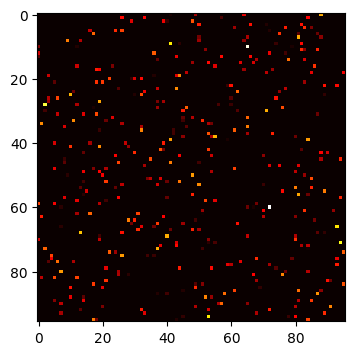

In [18]:
# generate the random addition matrix
# row is the source, column is the destination
a= np.eye(96)
a = random_choose_candidate(96,96,4)
show_matrix(a)
# randomly shuffle the rows
#np.random.shuffle(a)
# binarize the matrix as 0 and 1
a[a>0] = 1

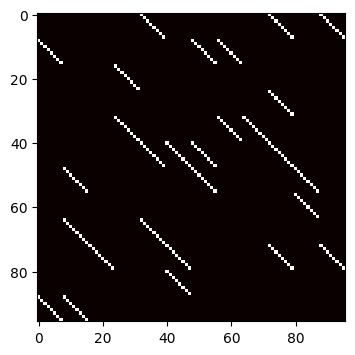

In [3]:
# generate the non-symmetric matrix
# devide a 96*96 matrix into 12*12 8*8 matrix
# randomly choose n matrix to add a diagonal matrix
a = np.zeros((96,96))
# randomly pick n number from 0 to 144
picked_submatrix = np.random.choice(144, 28, replace=False)
n = 0
for i in range(12):
    for j in range(12):
        if n in picked_submatrix:
            a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8)
        n += 1
show_matrix(a)

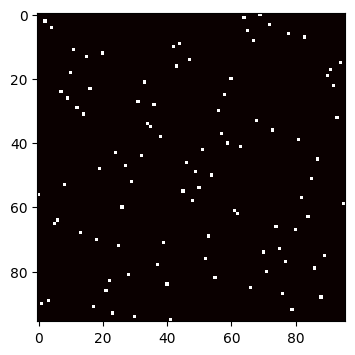

In [4]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
show_matrix(column_permutation)

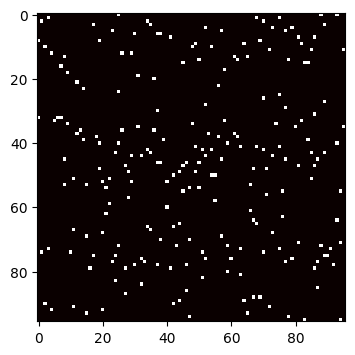

In [5]:
a = np.dot(a, column_permutation)
show_matrix(a)

In [6]:
# generate the job pair
jobs = np.argwhere(a)
volume = [a[i,j] for i,j in jobs]
volume = np.array(volume)
#distance_matrix = calculate_distance_matrix(jobs)
#S,E = calculate_S_E(jobs)
#D_prime = calculate_D_prime(D, S, E)

In [ ]:
test_cost, test_P, test_seq = CVRP_QAP(jobs,iteration=5)

iter=0, cost=211.0 after CVRP
iter=0, cost=203.0 after QAP
iter=1, cost=186.0 after CVRP


/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))
/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=1, cost=185.0 after QAP
iter=2, cost=185.0 after CVRP
iter=2, cost=182.0 after QAP
iter=3, cost=170.0 after CVRP
iter=3, cost=169.0 after QAP
iter=4, cost=177.0 after CVRP


# something is wrong: the cost does not match 

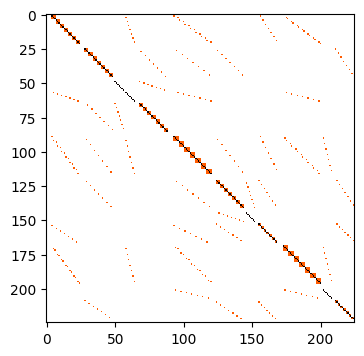

In [43]:
update_a = np.dot(a, test_P)
update_jobs = np.argwhere(update_a)
distance_matrix = calculate_distance_matrix(update_jobs)
show_matrix(distance_matrix)
# VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
# recorder = get_optimized_sequence(VRP_recorder)
# sequence = recorder.flatten()
# sequence = sequence[sequence!=-1] -1

dist = 0
for batched_ids in test_seq: 
    for i in range(len(batched_ids) - 1):
        if batched_ids[i] != -1 and batched_ids[i+1] != -1:
            dist += distance_matrix[batched_ids[i], batched_ids[i+1]]
dist

IndexError: index 379 is out of bounds for axis 0 with size 225

In [15]:
update_a = np.dot(a, test_P)
update_jobs = np.argwhere(update_a)
distance_matrix = calculate_distance_matrix(update_jobs)
VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
recorder = get_optimized_sequence(VRP_recorder)

Objective: 178


In [7]:
sequence = recorder.flatten()
sequence = sequence[sequence!=-1] -1
command_line = print_command(sequence,jobs)
np.savetxt('optimized_command_line.csv',command_line,fmt='%s',delimiter=',')

In [8]:
jobs = np.argwhere(a)
unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs)
np.savetxt('unoptimized_command_line.csv',unoptimized_command_line,fmt='%s',delimiter=',')

In [4]:
stat = []
for i in range(1,20):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance,recorder = CVRP_QAP(jobs,iteration=20)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

Objective: 89
iter=0, cost=89.0 after CVRP
iter=0, cost=53.0 after QAP
Objective: 56
iter=1, cost=56.0 after CVRP
iter=1, cost=54.0 after QAP
Objective: 53
iter=2, cost=53.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=2, cost=52.0 after QAP
Objective: 49
iter=3, cost=49.0 after CVRP
iter=3, cost=49.0 after QAP
Objective: 49
iter=4, cost=49.0 after CVRP
iter=4, cost=49.0 after QAP
Objective: 49
iter=5, cost=49.0 after CVRP
iter=5, cost=49.0 after QAP
Objective: 49
iter=6, cost=49.0 after CVRP
iter=6, cost=49.0 after QAP
Objective: 49
iter=7, cost=49.0 after CVRP
iter=7, cost=49.0 after QAP
Objective: 49
iter=8, cost=49.0 after CVRP
iter=8, cost=49.0 after QAP
Objective: 49
iter=9, cost=49.0 after CVRP
iter=9, cost=49.0 after QAP
Objective: 49
iter=10, cost=49.0 after CVRP
iter=10, cost=49.0 after QAP
Objective: 49
iter=11, cost=49.0 after CVRP
iter=11, cost=49.0 after QAP
Objective: 49
iter=12, cost=49.0 after CVRP
iter=12, cost=49.0 after QAP
Objective: 49
iter=13, cost=49.0 after CVRP
iter=13, cost=49.0 after QAP
Objective: 49
iter=14, cost=49.0 after CVRP
iter=14, cost=49.0 after QAP
Objective: 49
iter=15, cost=49.0 after CVRP
iter=15, cost=49.0 after QAP
Objective: 49
iter=16, cost=49.0 afte

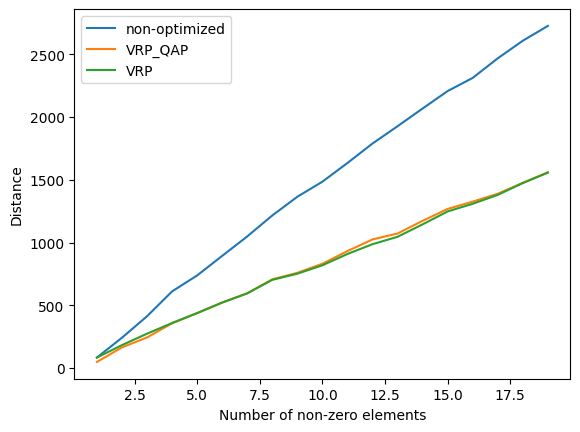

In [5]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.plot(stat[:,0],stat[:,3],label='VRP')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [5]:
def matrix_to_sequence(matrix,optimization_iteration=5):
    jobs = np.argwhere(matrix)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance,P = CVRP_QAP(jobs,iteration=optimization_iteration)
    updated_matrix = np.dot(matrix,P)
    updated_jobs = np.argwhere(updated_matrix)
    distance_matrix = calculate_distance_matrix(updated_jobs)
    optimized_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    return non_optimized_distance, optimized_distance

Objective: 34
iter=0, cost=34.0 after CVRP


/home/roger/miniforge3/envs/pipette_opt/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=0, cost=34.0 after QAP
Objective: 34
iter=1, cost=34.0 after CVRP
iter=1, cost=34.0 after QAP
Objective: 47
iter=2, cost=47.0 after CVRP
iter=2, cost=47.0 after QAP
Objective: 34
iter=3, cost=34.0 after CVRP
iter=3, cost=34.0 after QAP
Objective: 34
iter=4, cost=34.0 after CVRP
iter=4, cost=34.0 after QAP
Objective: 13


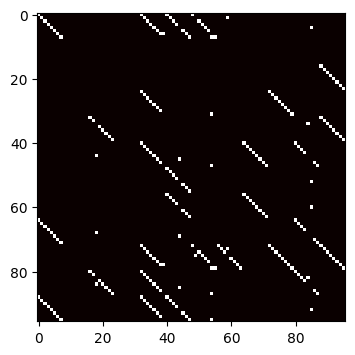

Objective: 80
iter=0, cost=80.0 after CVRP
iter=0, cost=77.0 after QAP
Objective: 85
iter=1, cost=85.0 after CVRP
iter=1, cost=85.0 after QAP
Objective: 49
iter=2, cost=49.0 after CVRP
iter=2, cost=49.0 after QAP
Objective: 53
iter=3, cost=53.0 after CVRP
iter=3, cost=53.0 after QAP
Objective: 53
iter=4, cost=53.0 after CVRP
iter=4, cost=53.0 after QAP
Objective: 35


In [6]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]
# record the optimized distance and non-optimized distance in each permutation
update_a = a
stat = []
optimized_distance, non_optimized_distance = matrix_to_sequence(update_a)
stat.append((0,non_optimized_distance,optimized_distance))
# pick an integer from 0 to 10 with gaussian distribution
for i in range(1):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
    update_a = np.dot(a, column_permutation)
    show_matrix(update_a)
    non_optimized_distance, optimized_distance = matrix_to_sequence(update_a)
    stat.append((i+1,non_optimized_distance,optimized_distance))
stat = np.array(stat)

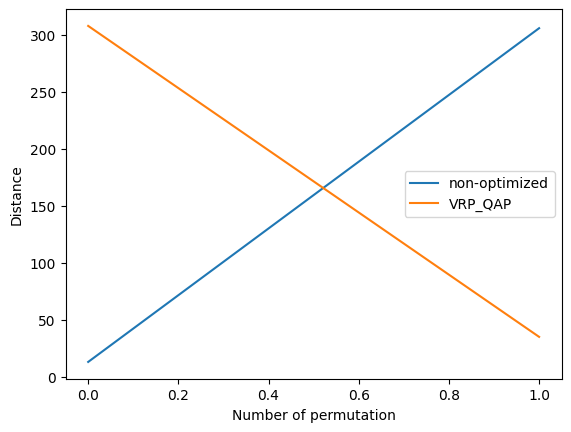

In [7]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.legend()
plt.xlabel('Number of permutation')
plt.ylabel('Distance')
plt.show()
